In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.decomposition import PCA
from scipy.stats import boxcox
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold,
                                    cross_val_score, GridSearchCV, learning_curve,
                                    validation_curve)
from sklearn.pipeline import Pipeline
from sklearn.base import (BaseEstimator, TransformerMixin)

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              ExtraTreesClassifier, GradientBoostingClassifier)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import (XGBClassifier, plot_importance)


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('glass.csv')
features = df.columns[:-1].tolist()
print(df.shape)
df.head(2)

(214, 10)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1


## Summerizing data

#### Descriptive  statistics

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RI,214.0,1.518365,0.003037,1.51115,1.516523,1.51768,1.519157,1.53393
Na,214.0,13.407850,0.816604,10.73000,12.907500,13.30000,13.825000,17.38000
Mg,214.0,2.684533,1.442408,0.00000,2.115000,3.48000,3.600000,4.49000
Al,214.0,1.444907,0.499270,0.29000,1.190000,1.36000,1.630000,3.50000
Si,214.0,72.650935,0.774546,69.81000,72.280000,72.79000,73.087500,75.41000
K,214.0,0.497056,0.652192,0.00000,0.122500,0.55500,0.610000,6.21000
Ca,214.0,8.956963,1.423153,5.43000,8.240000,8.60000,9.172500,16.19000
Ba,214.0,0.175047,0.497219,0.00000,0.000000,0.00000,0.000000,3.15000
Fe,214.0,0.057009,0.097439,0.00000,0.000000,0.00000,0.100000,0.51000
Type,214.0,2.780374,2.103739,1.00000,1.000000,2.00000,3.000000,7.00000


In [5]:
df.Type.value_counts()
# Unbalanced dataset

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

## Data visualization

* **Univariate plots**

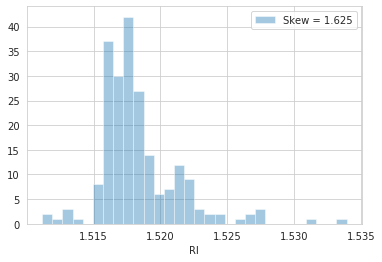

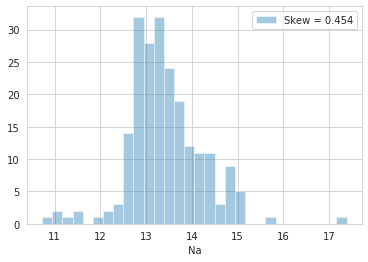

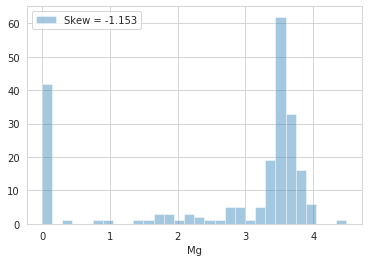

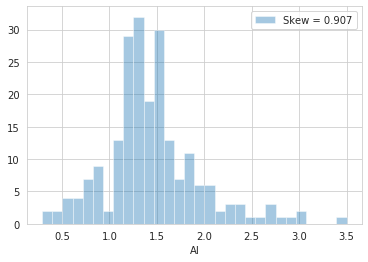

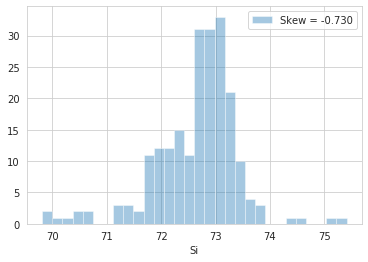

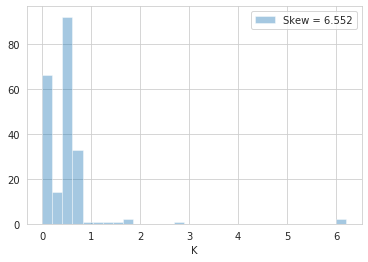

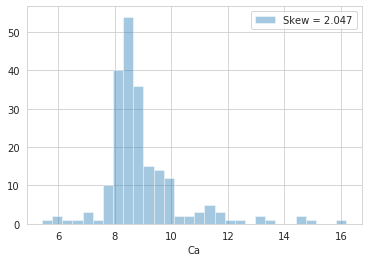

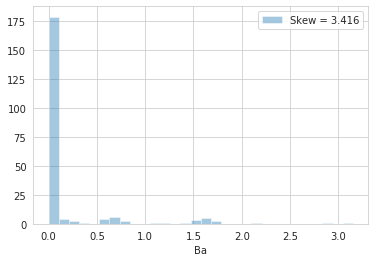

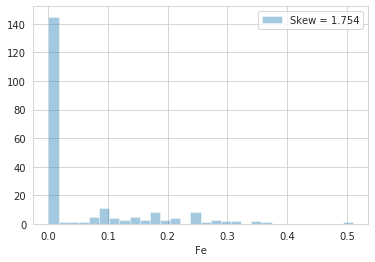

In [6]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde=False, label='Skew = %.3f' % (skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [15]:
# Fe, Ba, Ca and K => The most skewness
# there are plenty of outliers in variables = {'Ba', 'K'}
# Using Turkey method to detect outliers

from collections import Counter

def anomaly_hunter(df):
    """
    Take a df as input and return a list of indices
    corresponding to observations containing more than 2 outliers
    """
    outliers_indices = []
    for col in df.columns.tolist():
        #1st quartile (%25)
        Q1 = np.percentile(df[col],25)
        
        # 3rd quantile(%75)
        Q3 = np.percentile(df[col], 75)
        
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = 1.5* IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        #append the found outlier indices for col to the list of outlier indices
        outliers_indices.extend(outlier_list_col)
    
    #Select the outliers with more than 2 occurances
    
    outliers_indices = Counter(outliers_indices)
    multiple_outliers = list(k for k,v in outliers_indices.items() if v > 2)
    
    return multiple_outliers

print('The number of outliers detected in more than 2 variables are %d'% (len(anomaly_hunter(df[features]))))

The number of outliers detected in more than 2 variables are 14


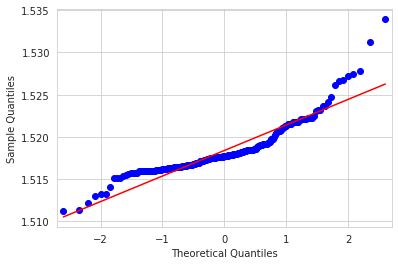

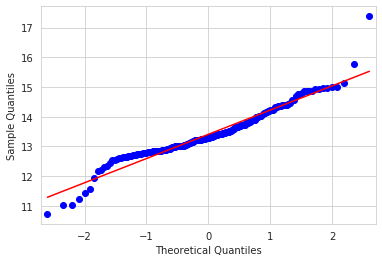

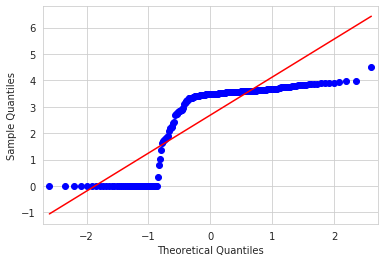

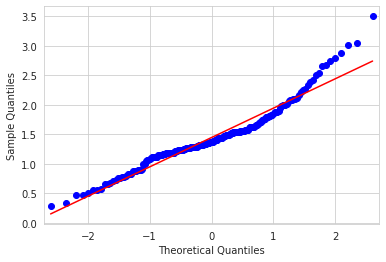

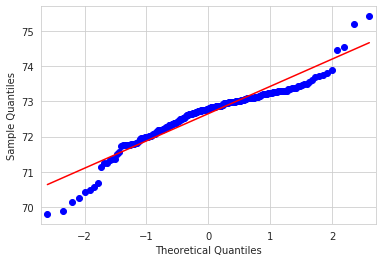

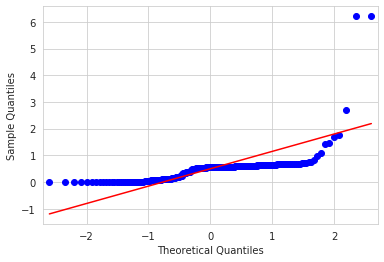

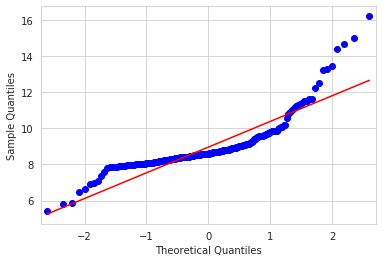

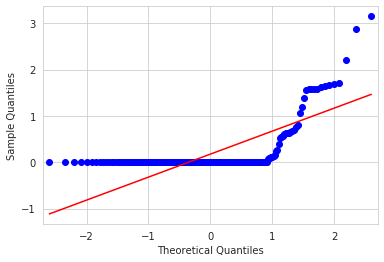

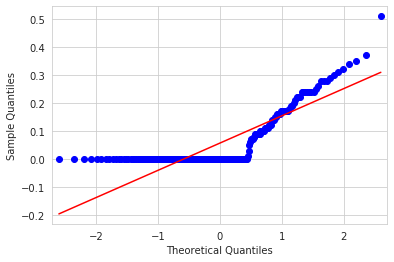

In [7]:
# Test if the data is normal | Quantile quantile plot

for feat in features:
    qqplot(df[feat], line='s')
    plt.show()


**We will get rid of the anomalies later**

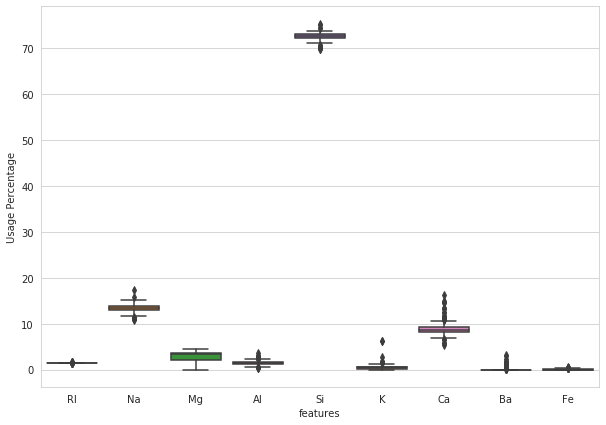

In [8]:
plt.figure(figsize=(10,7))
sns.boxplot(data=df[features])
plt.xlabel('features')
plt.ylabel('Usage Percentage')
plt.show()

In [9]:
def swarm_box_plot(df, plots_each_row, figsize=(15,12)):
    features = df.columns.tolist()
    num_features = len(features)
    rows = num_features // plots_each_row
    
    fig, axes = plt.subplots(nrows=rows, ncols=plots_each_row, figsize=figsize)
    i = 0
    for feat in features:
        r, c = divmod(features.index(feat), plots_each_row)
        sns.boxplot(data=df[feat],ax=axes[r, c])
        sns.swarmplot(data=df[feat], color="0.25", ax=axes[r, c])
        axes[r, c].set(xlabel=feat)
        plt.xlabel(feat)
    plt.show()

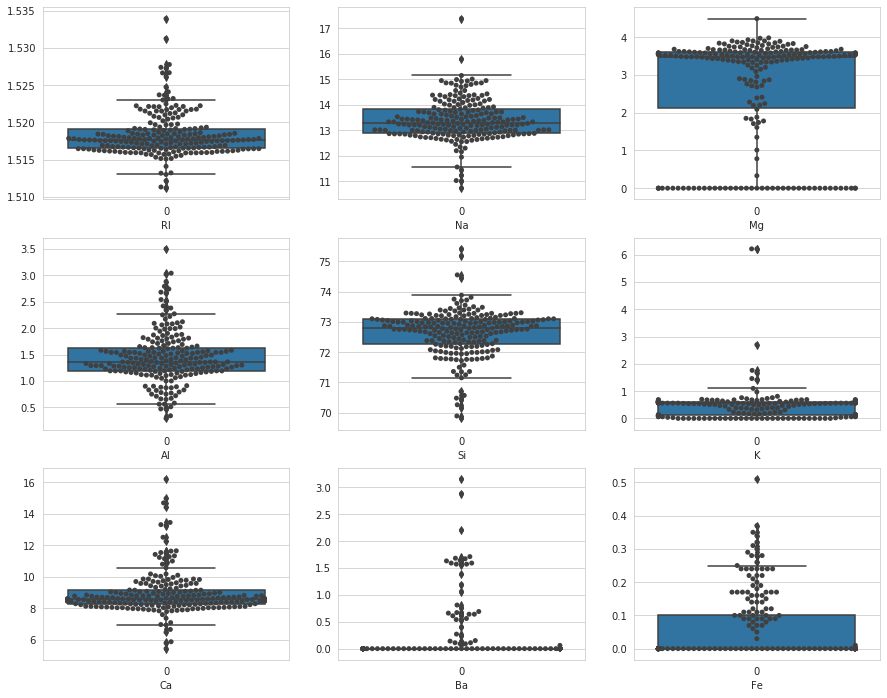

In [10]:
swarm_box_plot(df[features], 3, (15,12))

Silicon has more percentage in building glasses which is ok.
because glass is mostly made of glass

<Figure size 720x720 with 0 Axes>

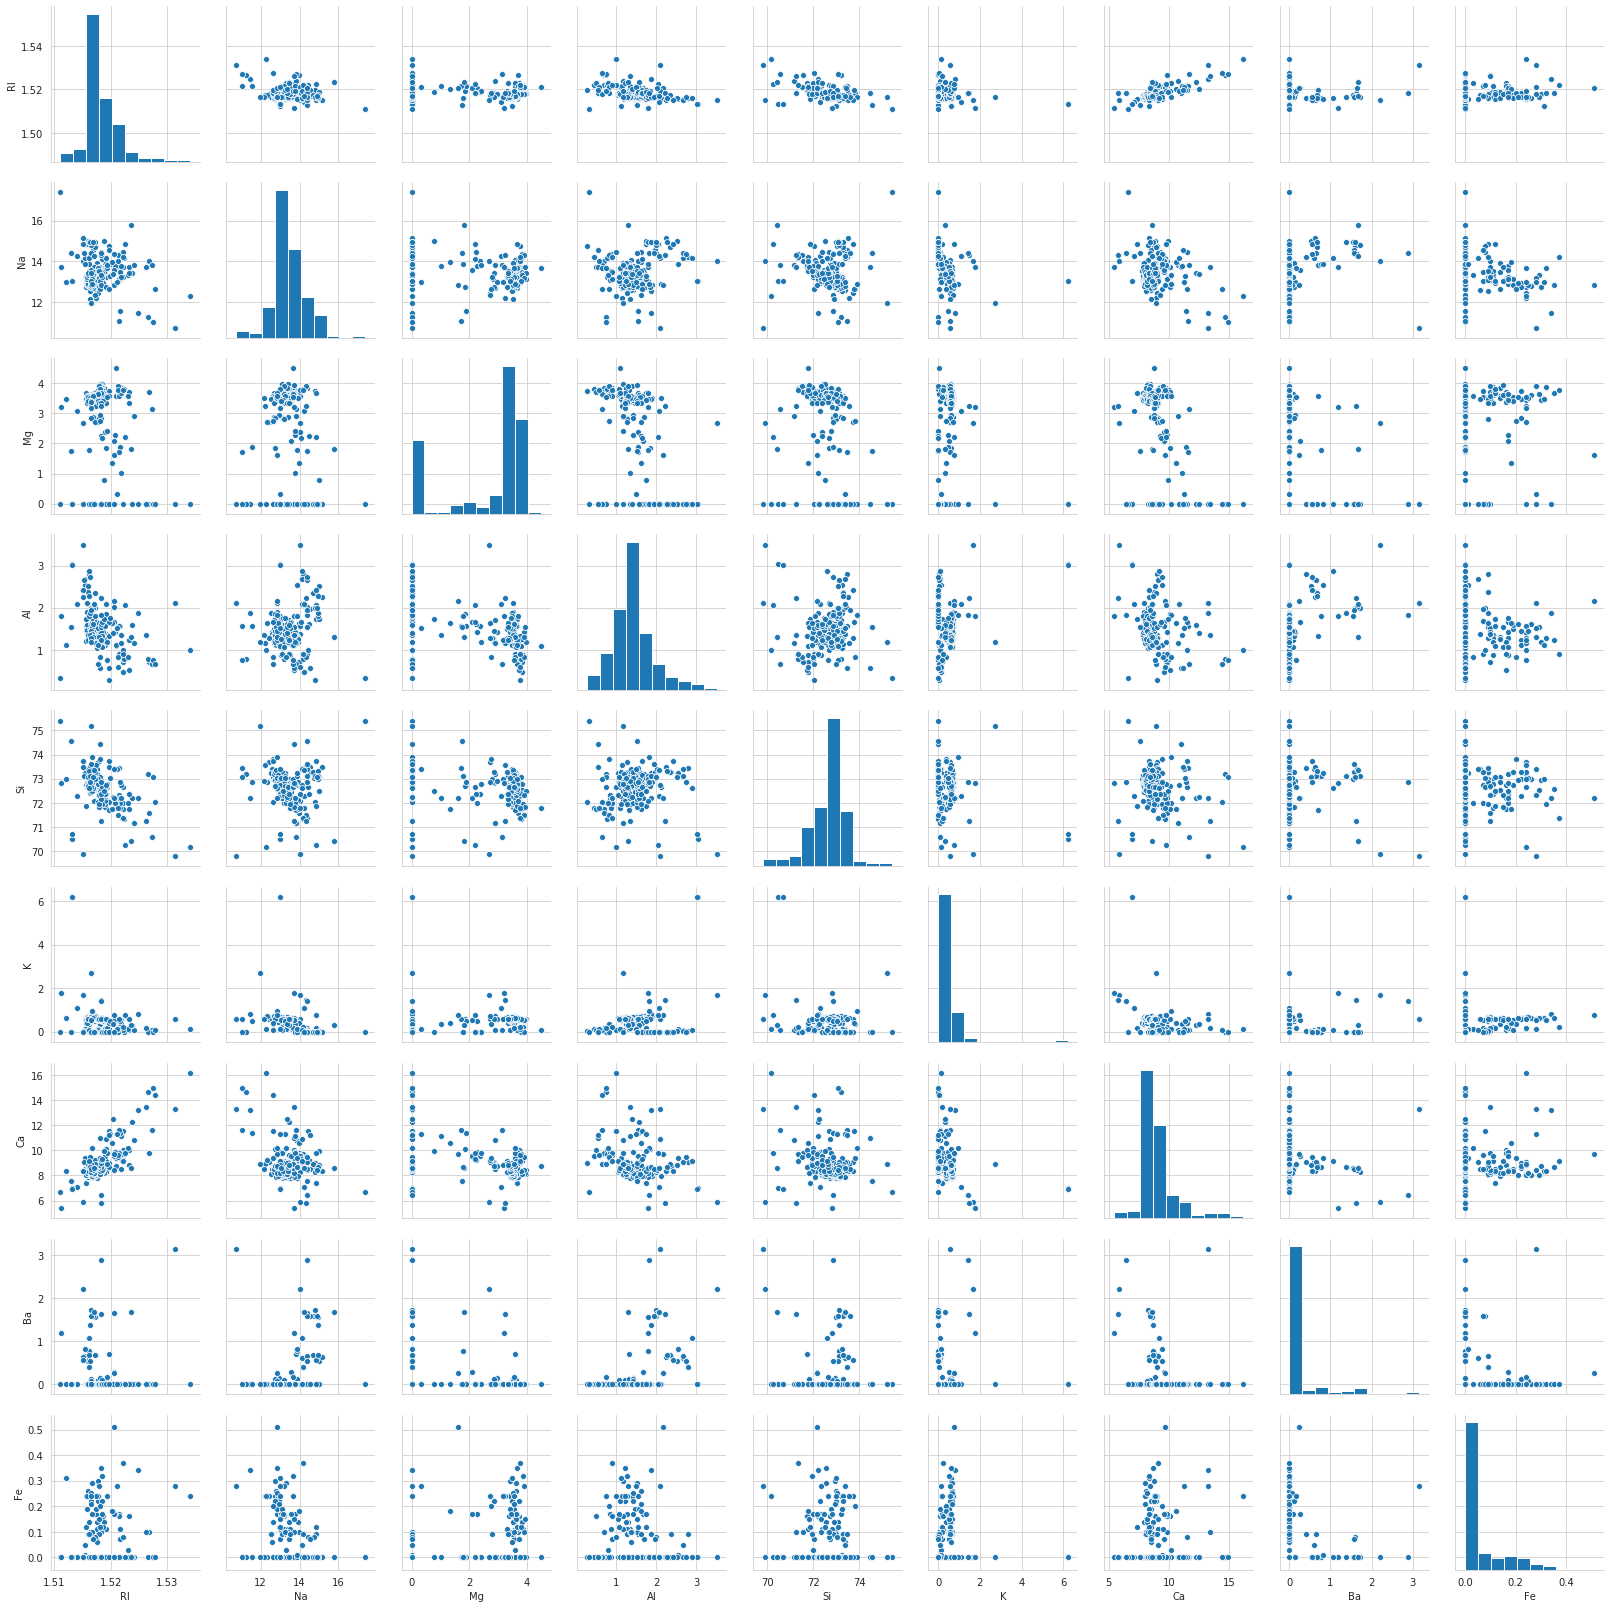

In [11]:
# Lets check out the pairplot
plt.figure(figsize=(10,10))
sns.pairplot(df[features])
plt.show()

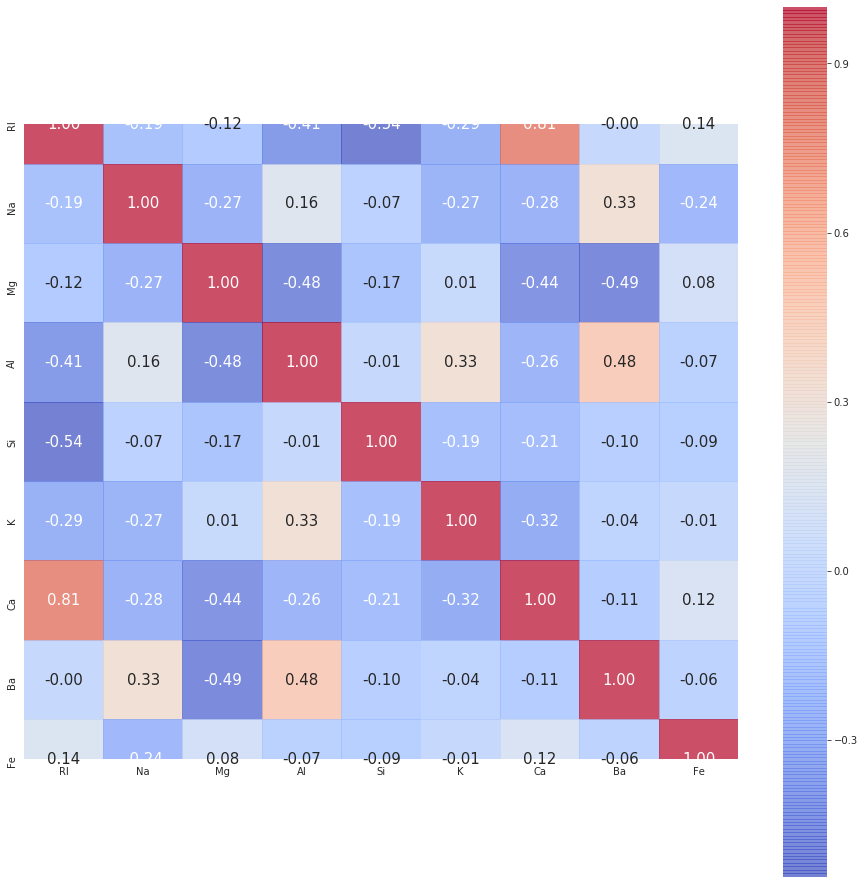

In [12]:
# Ri, Ca (+) - Na, Al (+) - Na, Si (-) - Al,Si (+)
# Time for heatmap
plt.figure(figsize=(16,16))
sns.heatmap(data=df[features].corr(), cbar=True, fmt='.2f', xticklabels= features, annot_kws={'size': 15},
            yticklabels=features, alpha=0.7, cmap='coolwarm', square=True, annot=True)
plt.show()

strong correlation between 'Ca' and 'Ri' | We might need to use PCA

## 3- Prepare data

### - Data Cleaning

In [13]:
df.info()

#This dataset is clean; there aren't any missing values in it.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
RI      214 non-null float64
Na      214 non-null float64
Mg      214 non-null float64
Al      214 non-null float64
Si      214 non-null float64
K       214 non-null float64
Ca      214 non-null float64
Ba      214 non-null float64
Fe      214 non-null float64
Type    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


### Lets remove the outliers 

In [16]:
outliers_indices = anomaly_hunter(df[features])
df = df.drop(outliers_indices).reset_index(drop=True)
print(df.shape)

(200, 10)


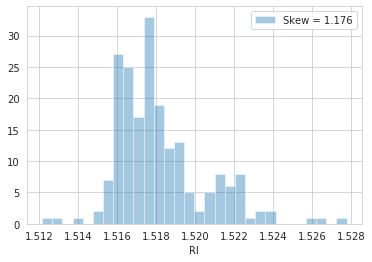

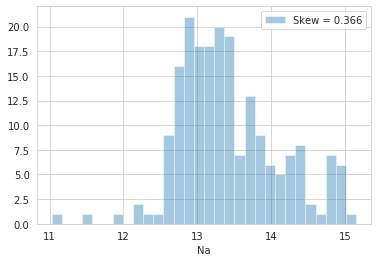

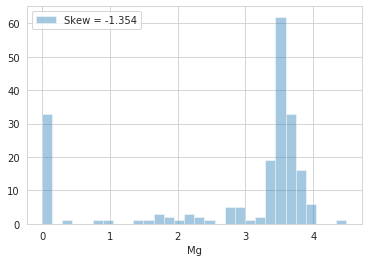

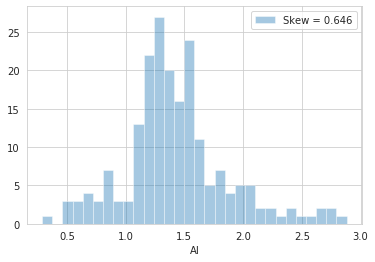

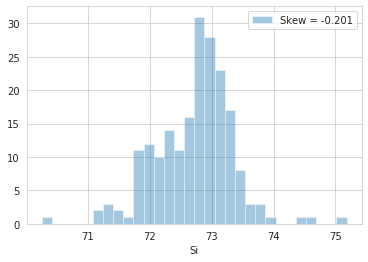

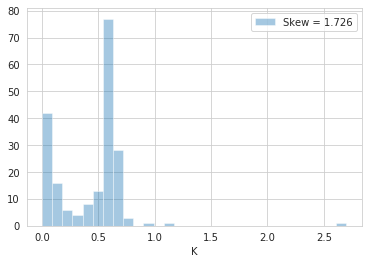

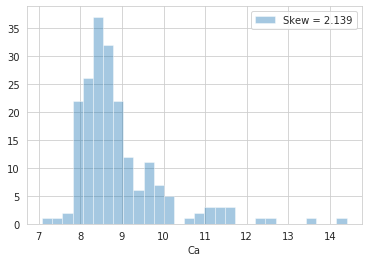

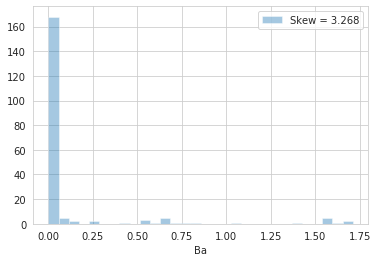

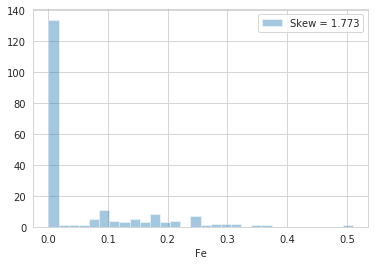

In [17]:
# Lets check the distribution again

for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde=False, label='Skew = %.3f'%(skew), bins=30)
    plt.legend(loc='best')
    plt.show()


In [18]:
df.Type.value_counts()

2    70
1    70
7    25
3    17
5    10
6     8
Name: Type, dtype: int64

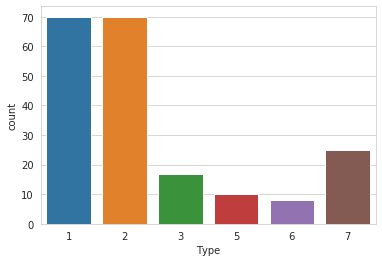

In [19]:
sns.countplot(df.Type)
plt.show()

## -split out validation dataset

In [20]:
# Define X as features and y as labels
df.Type = df.Type.apply(lambda x:4 if x==7 else x)
X = df[features]
y = df['Type']

seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state=seed)

In [21]:
features_boxcox = []

for feature in features:
    bc_transformed,_ = boxcox(df[feature]+1) # Shift by 1 to avoid computing log of negative values
    features_boxcox.append(bc_transformed)
    
features_boxcox = np.column_stack(features_boxcox) # numpy column_stack ?
df_bc = pd.DataFrame(data=features_boxcox, columns=features)
df_bc['Type'] = df['Type']

In [22]:
df_bc.describe().T

,count,mean,std,min,25%,50%,75%,max
RI,200.0,6.159461e-04,2.173846e-18,6.159461e-04,6.159461e-04,6.159461e-04,6.159461e-04,6.159461e-04
Na,200.0,9.106432e-01,3.075709e-03,8.979617e-01,9.085402e-01,9.102691e-01,9.124451e-01,9.177106e-01
Mg,200.0,1.481350e+01,8.011923e+00,0.000000e+00,1.056980e+01,1.855503e+01,1.983586e+01,3.140832e+01
Al,200.0,9.552443e-01,2.177019e-01,2.613738e-01,8.500765e-01,9.384768e-01,1.060851e+00,1.561947e+00
Si,200.0,6.067071e+09,2.873472e+08,5.004587e+09,5.893126e+09,6.106954e+09,6.238759e+09,7.293074e+09
K,200.0,3.428721e-01,2.135070e-01,0.000000e+00,1.229221e-01,4.474032e-01,4.805359e-01,1.392148e+00
Ca,200.0,1.999249e-01,8.577972e-07,1.999215e-01,1.999244e-01,1.999248e-01,1.999254e-01,1.999270e-01
Ba,200.0,1.337727e-02,3.118802e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.114198e-02
Fe,200.0,1.914097e-02,2.775737e-02,0.000000e+00,0.000000e+00,0.000000e+00,5.165217e-02,6.879590e-02
Type,200.0,2.295000e+00,1.395605e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00


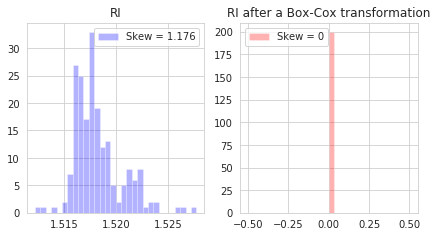

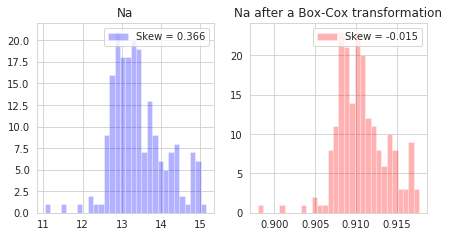

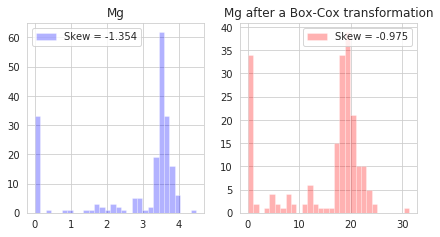

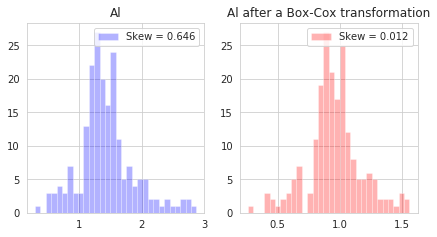

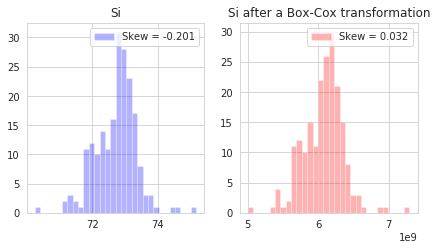

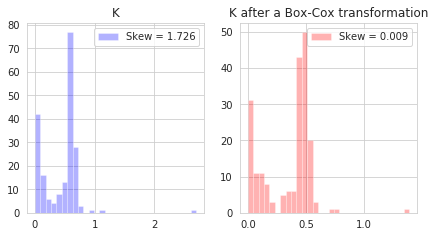

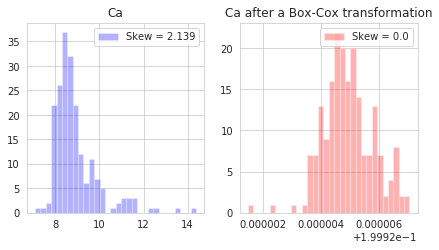

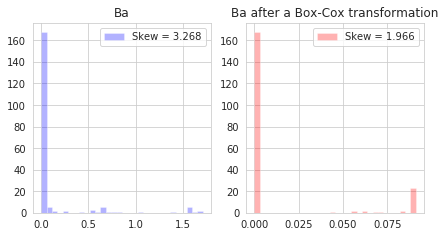

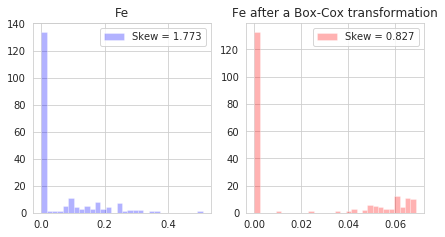

In [23]:
for feat in features:
    fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
    ax[0].hist(df[feat], color='blue', bins=30, alpha=0.3,
              label='Skew = %s'%(str(round(df[feat].skew(), 3))))
    ax[0].set_title(str(feat))
    ax[0].legend(loc=0)
    
    ax[1].hist(df_bc[feat], color='red', bins=30, alpha=0.3, 
              label='Skew = %s'% (str(round(df_bc[feat].skew(), 3))))
    ax[1].set_title(str(feat)+' after a Box-Cox transformation')
    ax[1].legend(loc=0)
    plt.show()

In [24]:
for feat in features:
    delta = np.abs( df_bc[feat].skew() / df[feat].skew() )
    if delta < 1.0:
        print('Feature %s is less skewed after a Box-Cox transform'%(feat))
    else:
        print('Feature %s is more skewed after a Box-Cox transform'% (feat))

Feature RI is less skewed after a Box-Cox transform
Feature Na is less skewed after a Box-Cox transform
Feature Mg is less skewed after a Box-Cox transform
Feature Al is less skewed after a Box-Cox transform
Feature Si is less skewed after a Box-Cox transform
Feature K is less skewed after a Box-Cox transform
Feature Ca is less skewed after a Box-Cox transform
Feature Ba is less skewed after a Box-Cox transform
Feature Fe is less skewed after a Box-Cox transform


The Box-Cox transformation seems to do a great job in reducing the skews of the different distributions of features. However, it does not lead to the normalization of the feature distributions.

**Dimensionlity reduction**

* **PCA**

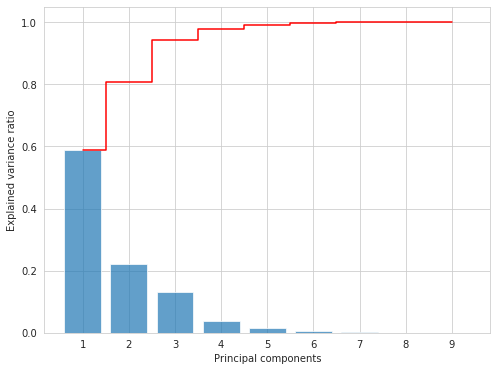

PC1 Cumulative variance: 58.837%
PC2 Cumulative variance: 80.887%
PC3 Cumulative variance: 94.102%
PC4 Cumulative variance: 97.748%
PC5 Cumulative variance: 99.159%
PC6 Cumulative variance: 99.752%
PC7 Cumulative variance: 99.977%
PC8 Cumulative variance: 100.000%
PC9 Cumulative variance: 100.000%


In [25]:
def pca_cumsum_plot(x_train, seed=None, cum_sum=True):
    
    pca = PCA(random_state=seed) if seed else PCA()
    pca.fit(x_train)
    var_exp = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)
    plt.figure(figsize=(8,6))
    plt.bar(range(1, len(cum_var_exp)+1), var_exp, align= 'center',
            label='individual variance explained', alpha=0.7)
    plt.step(range(1, len(cum_var_exp)+1), cum_var_exp, where= 'mid',
             label='cumulative variance explained', color='red')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xticks(np.arange(1, len(var_exp)+1, 1))
    plt.show()
    
    # Cumulative variance explained
    if cum_sum:
        for i, sum in enumerate(cum_var_exp):
            print("PC" + str(i+1), "Cumulative variance: %.3f" %(cum_var_exp[i]*100)+"%")

pca_cumsum_plot(X_train, seed=seed)

## - Lets compare the algorithms

SVC: 71.430587 (+/- 8.222655) performed in 1.217752 seconds
KNN: 67.772914 (+/- 10.418318) performed in 0.047665 seconds
RF: 78.815797 (+/- 9.413551) performed in 0.489428 seconds
Ada: 46.211231 (+/- 7.623465) performed in 0.637288 seconds
ET: 75.904677 (+/- 6.876377) performed in 0.430662 seconds
GB: 74.319647 (+/- 9.339264) performed in 0.943404 seconds
LR: 70.025502 (+/- 9.168266) performed in 0.048089 seconds


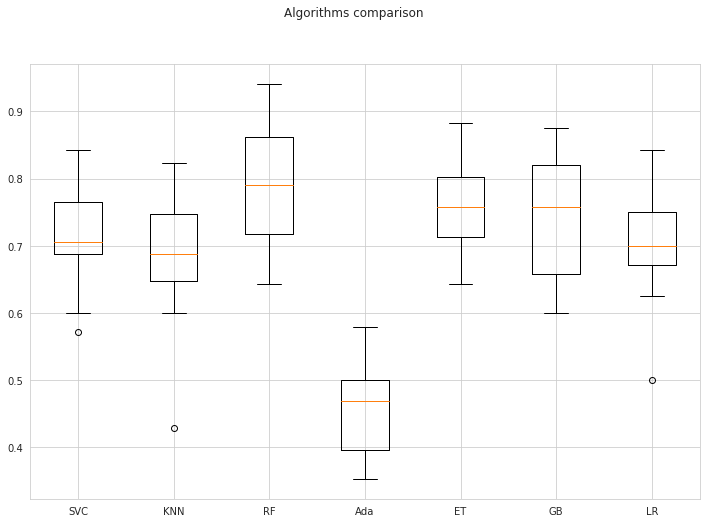

In [26]:
from time import time

n_components = 5
pipelines = []
n_estimators = 200

pipelines.append(('SVC', 
                  Pipeline([
                            ('sc', StandardScaler()),
#                            ('pca', PCA(n_components=n_components, random_state=seed)),
                            ('SVC', SVC(random_state=seed))])))

pipelines.append(('KNN', 
                     Pipeline([
                             ('sc',StandardScaler()),
#                             ('pca', PCA(n_components=n_components, random_state=seed)),
                             ('KNN', KNeighborsClassifier())])))

pipelines.append( ('RF',
                  Pipeline([
                          ('sc', StandardScaler()),
#                      ('pca', PCA(n_components=n_components, random_state=seed)),
                      ('RF', RandomForestClassifier(random_state=seed, n_estimators=n_estimators))])))

pipelines.append( ('Ada', 
                  Pipeline([
                      ('sc', StandardScaler()),
#                      ('pca', PCA(n_components=n_components, random_state=seed)),
                      ('Ada', AdaBoostClassifier(random_state=seed, n_estimators=n_estimators))])))

pipelines.append( ('ET',
                   Pipeline([
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('ET', ExtraTreesClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))
pipelines.append( ('GB',
                   Pipeline([ 
                             ('sc', StandardScaler()),
#                             ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('GB', GradientBoostingClassifier(random_state=seed)) ]) ))

pipelines.append( ('LR',
                   Pipeline([
                              ('sc', StandardScaler()),
#                               ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('LR', LogisticRegression(random_state=seed)) ]) ))


results, names, times  = [], [] , []
num_folds = 10
scoring = 'accuracy'

for name, model in pipelines:
    start = time()
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring,
                                n_jobs=5)
    t_elapsed = time() - start
    results.append(cv_results)
    names.append(name)
    times.append(t_elapsed)
    msg = "%s: %f (+/- %f) performed in %f seconds" % (name, 100*cv_results.mean(), 
                                                       100*cv_results.std(), t_elapsed)
    print(msg)


fig = plt.figure(figsize=(12,8))    
fig.suptitle("Algorithms comparison")
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


In [27]:
for name, model in pipelines:
    print("{} scored =>".format(name), model.fit(X_train, y_train).score(X_test, y_test))

SVC scored => 0.675
KNN scored => 0.65
RF scored => 0.8
Ada scored => 0.425
ET scored => 0.775
GB scored => 0.775
LR scored => 0.65
